In [1]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt

# Image and mask vizualization

In [2]:
splits = ["train_id", "val_id"]
splits_samples = {}

for split in splits:
    with open(f'/storage/AIDA_PROJECTS/egor.koptelov/MIL_test_task/hierarchical_segmentation/data/{split}.txt') as f:
        splits_samples[split] = f.read().splitlines()
    print(f"The {split} split has {len(splits_samples[split])} samples")

The train_id split has 2826 samples
The val_id split has 707 samples


In [3]:
path_to_raw = '/storage/AIDA_PROJECTS/egor.koptelov/MIL_test_task/Pascal-part/Pascal-part'

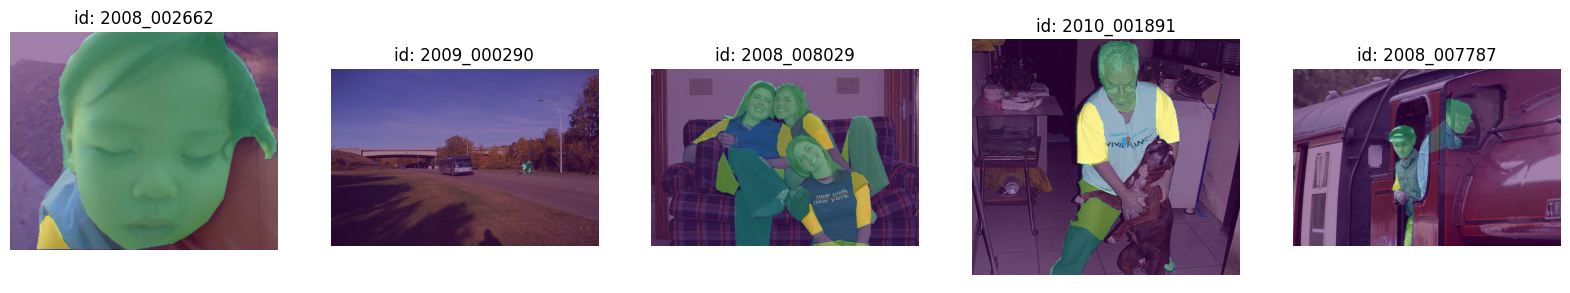

In [4]:
num_imgs = 5
split = 'val_id'

fig, axs = plt.subplots(1, num_imgs, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(20)

for j, idx in enumerate(np.random.randint(0, len(splits_samples[split]), num_imgs)):
    idx_img = splits_samples[split][idx]

    mask = np.load(f'{path_to_raw}/gt_masks/{idx_img}.npy')
    image = cv2.imread(f'{path_to_raw}/JPEGImages/{idx_img}.jpg')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    axs[j].imshow(image)
    axs[j].imshow(mask, alpha=0.5)
    axs[j].set_title(f'id: {idx_img}')
    axs[j].axis('off')
    
plt.show()

In [5]:
print(f'Shape of mask: {mask.shape}')
print(f'Image shape: {image.shape}')
print(f'Unique values of mask: {np.unique(mask)}')

Shape of mask: (331, 500)
Image shape: (331, 500, 3)
Unique values of mask: [0 1 2 4 5 6]


### Tmp tests

In [8]:
import torch
from torchvision import transforms
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn


/storage/conda/envs/env_qc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
print(mask.shape)
print(image.shape)

(331, 500)
(331, 500, 3)


In [10]:
tf_mask = torch.tensor(mask)
tf_image = torch.tensor(image, dtype=torch.float32)
tf_image = tf_image.permute(2, 0, 1)
print(tf_mask.shape)
print(tf_image.shape)

torch.Size([331, 500])
torch.Size([3, 331, 500])


In [11]:
  t = transforms.Compose([
        transforms.Resize((256, 256))
    ])

In [12]:
t(tf_mask.unsqueeze(0)).shape

torch.Size([1, 256, 256])

In [13]:
print(t(tf_mask.unsqueeze(0)).shape)
print(t(tf_image).shape)

torch.Size([1, 256, 256])
torch.Size([3, 256, 256])


In [104]:
model = smp.DeepLabV3(
            encoder_name='resnet34',        # The name of the encoder
            encoder_weights='imagenet',  # Pre-trained weights for the encoder
            classes=7,                     # Output classes (not needed for custom decoders)
            activation=None,                   # No activation function (to be applied later)
            # decoder_channels=dec_conv_shapes
        )

In [105]:
model

DeepLabV3(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [108]:
model.decoder.out_channels

256

In [114]:
batch_tf_image = torch.rand(2, 3, 512, 512)
print(batch_tf_image.shape)

enc_img = model.encoder(t(batch_tf_image))[-1]
print(enc_img.shape)

dec_img = model.decoder(enc_img)
print(dec_img.shape)

res = model(batch_tf_image)
print(res.shape)

torch.Size([2, 3, 512, 512])
torch.Size([2, 512, 32, 32])
torch.Size([2, 256, 32, 32])
torch.Size([2, 7, 512, 512])


In [97]:
# model.eval()
enc_img = model.encoder(t(tf_image).unsqueeze(0))[-1]
print(enc_img.shape)

dec_img = model.decoder(enc_img)
print(dec_img.shape)

torch.Size([1, 512, 32, 32])


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])

In [59]:
print(t(tf_image).unsqueeze(0).shape)

torch.Size([1, 3, 256, 256])


In [62]:
model.encoder(t(tf_image).unsqueeze(0))[-1].shape

torch.Size([1, 512, 32, 32])

In [99]:
# l1 = model.decoder.blocks[0].conv1(torch.rand(1, 768, 8, 8))
# print(l1.shape)

# l2 = model.decoder.blocks[1].conv1(torch.rand(1, 384, 8, 8))
# print(l2.shape)

!!!!!!!!! между слоями почему то меняется размерность каналов!!!!

In [27]:
model.decoder.blocks[:2]

TypeError: unhashable type: 'slice'

In [31]:
from segmentation_models_pytorch.encoders import get_preprocessing_fn

preprocess_input = get_preprocessing_fn('resnet34', pretrained='imagenet')

In [112]:
from torchsummary import summary
summary(model, input_size=(3, 512, 512))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [208]:
model.decoder.blocks[-1].conv2[0].out_channels

16

In [184]:
from segmentation_models_pytorch.losses import JaccardLoss
loss = JaccardLoss(mode='multiclass',
                    # from_logits=False
                    # classes=2
                     )

In [191]:
# batched_image = tf_image.unsqueeze(0).reshape((1, 6, 331, 500))
batched_image = torch.ones(32, 2, 256, 256).float()
# batched_mask = tf_mask.unsqueeze(0)
batched_mask = torch.ones(32, 1, 256, 256).long()
# batched_mask = F.one_hot(batched_mask, 6)

print(batched_image.shape, batched_mask.shape)
print(batched_image.dtype, batched_mask.dtype)

torch.Size([32, 2, 256, 256]) torch.Size([32, 1, 256, 256])
torch.float32 torch.int64


In [192]:
loss(batched_image, batched_mask)

tensor(0.2500)